In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import array_to_latex as a2l
import os
import pickle
from tqdm import tqdm
sns.set_theme()
np.set_printoptions(suppress = True)

In [2]:
datadir = os.getcwd()
onlyfiles = [f for f in os.listdir(datadir) if (os.path.isfile(os.path.join(datadir, f)))&(f[-3:]=='pkl')&('obs' not in f)]
file = []
for i in onlyfiles:
    with open(i, 'rb') as f:
        temp = pickle.load(f)
        file = file + temp

In [3]:
θss = []
for f in tqdm(file):
    θs = []
    for i in f:
        try:
            if np.isnan(i[0].fun) == False:
                θs.append(i[0])
        except:
            pass
    if len(θs) != 0:
        fun = pd.DataFrame([i.fun for i in θs])
        nit = pd.DataFrame([i.nit for i in θs])
        success = pd.DataFrame([i.success for i in θs])
        message = pd.DataFrame([i.message for i in θs])
        λ = pd.DataFrame([i.x[0] for i in θs])
        η = pd.DataFrame([i.x[1] for i in θs])
        b11 = pd.DataFrame([i.x[2] for i in θs])
        b22 = pd.DataFrame([i.x[3] for i in θs])
        eig1 = pd.DataFrame([isinstance(np.linalg.eig(np.array([i.x[4:7],i.x[8:11],i.x[12:15]]))[0][0], complex) for i in θs])
        eig2 = pd.DataFrame([isinstance(np.linalg.eig(np.array([i.x[4:7],i.x[8:11],i.x[12:15]]))[0][1], complex) for i in θs])
        eig3 = pd.DataFrame([isinstance(np.linalg.eig(np.array([i.x[4:7],i.x[8:11],i.x[12:15]]))[0][2], complex) for i in θs])
        stable = pd.DataFrame([np.max(np.linalg.eig(np.array([i.x[4:7],i.x[8:11],i.x[12:15]]))[0])<1 for i in θs])
        hess = pd.DataFrame([np.all(np.linalg.eigvals(i.hess_inv.todense()) >=0) for i in θs])
        res = pd.concat([fun, nit, success, message, λ, η, b11, b22, eig1, eig2, eig3, stable, hess], axis = 1)
        res.columns = ['ll','nit','success','message','λ','η','b11','b22', 'eig1', 'eig2', 'eig3', 'stable','hess']
        res = res.loc[res['success']==True]
        res = res.loc[res['stable']==True]
        res = res.loc[res['hess']==True]
        res = res.loc[res['eig1']==False]
        res = res.loc[res['eig2']==False]
        res = res.loc[res['eig3']==False]
        res = res.sort_values(by = 'll',ascending = True)
        try:
            θ = θs[res.index[0]].x
            θss.append(θ)
        except:
            pass
    else:
        pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4900/4900 [00:04<00:00, 1053.34it/s]


In [4]:
len(θss)

1333

In [5]:
res

,ll,nit,success,message,λ,η,b11,b22,eig1,eig2,eig3,stable,hess
0,1959.971619,75,True,b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPS...,0.79563,-0.012169,1.196636,0.629686,False,False,False,True,True


In [6]:
df_results = pd.concat([pd.DataFrame(i) for i in θss],axis=1)
# dfa = df_results.T
# dfa.columns = θ_name
# df_results = dfa.loc[dfa['λ']!=0].T

In [7]:
pd.DataFrame([np.max(np.linalg.eig(np.array([i[4:7],i[8:11],i[12:15]]))[0]) for i in θss])

,0
0,0.609139
1,0.900132
2,0.749161
3,0.743162
4,0.742255
...,...
1328,0.815662
1329,0.798672
1330,0.858374
1331,0.779337


In [8]:
λ, η = 0.8, 0
b11, b22 = 1, 0.5

As11, As12, As13, As14 = 0.6, 0.1, 0.1, 9
As21, As22, As23, As24 = 0.2, 0.5, 0.3, 8
As31, As32, As33, As34 = 0.1, 0.2, 0.4, 6

Bs11, Bs21, Bs22, Bs31, Bs32, Bs33 = 3, 0.5, 2, 0.3, 0.2, 1

θ = np.array([λ, η, \
              b11, b22,\
              As11, As12, As13, As14, \
              As21, As22, As23, As24, \
              As31, As32, As33, As34, \
              Bs11, Bs21, Bs22, Bs31, Bs32, Bs33])
df_true = pd.DataFrame(θ)

θ_name = ['λ', 'η', \
            'b11', 'b22', \
            'As11', 'As12', 'As13', 'Aso1', \
            'As21', 'As22', 'As23', 'Aso2', \
            'As31', 'As32', 'As33', 'Aso3', \
            'Bs11', 'Bs21', 'Bs22', 'Bs31', 'Bs32', 'Bs33']

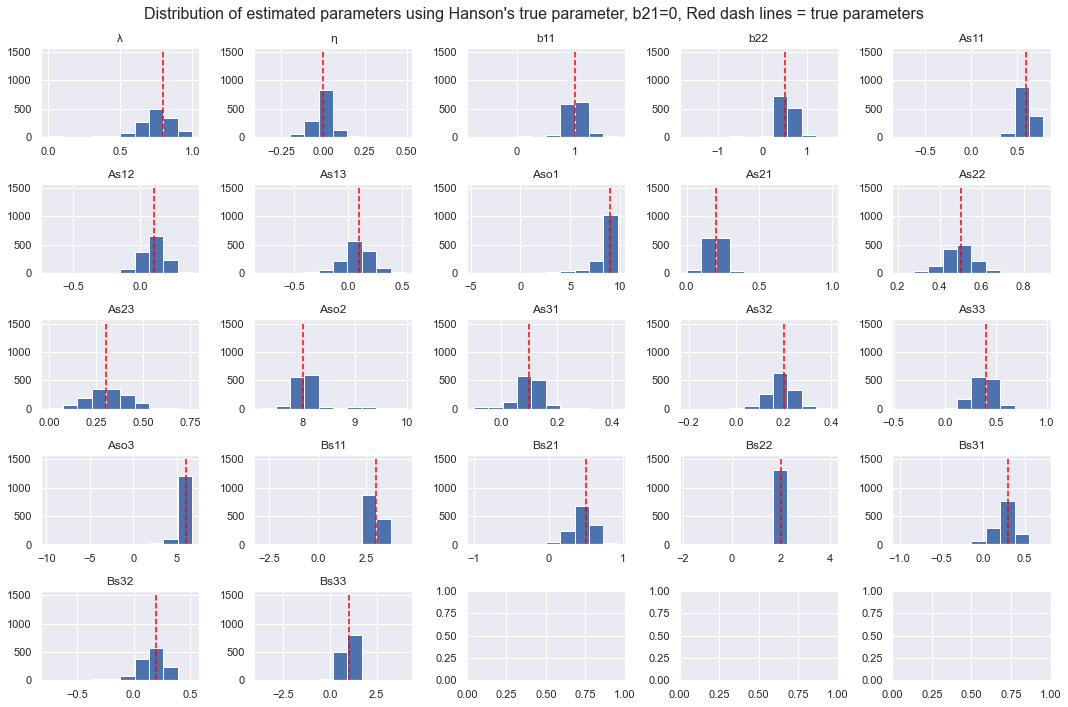

In [11]:
fig, axes = plt.subplots(5,5,figsize = (15,10))
for v, ax in enumerate(axes.flatten()):
    if v == 22:
        break
    ax.hist(df_results.iloc[v,:])
    ax.set_title(θ_name[v])
    ax.vlines(df_true.iloc[v,:],0,1500,color='red',linestyle = '--')
fig.suptitle('Distribution of estimated parameters using Hanson\'s true parameter, b21=0, Red dash lines = true parameters', fontsize=16)
fig.tight_layout()
fig.savefig('Simulation.png',dpi = 400, bbox_inches = "tight")